In [1]:
import os
from graph_partitioning import GraphPartitioning

pwd = %pwd

config = {

    "DATA_FILENAME": os.path.join(pwd, "data", "oneshot_fennel_weights.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "SCOTCH",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "FENNEL",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd, "data", "simulated_arrival.txt"),

    # File containing the geographic location of each node.
    "POPULATION_LOCATION_FILE": os.path.join(pwd, "data", "population_location.csv"),

    # Number of shelters
    "num_partitions": 4,

    # The number of iterations when making prediction model
    "num_iterations": 10,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.10,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 10,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,


    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": True,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": True,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    
    # Path to the scotch shared library
    "SCOTCH_LIB_PATH": "/usr/local/lib/libscotch.so",

    "SCOTCH_PYLIB_REL_PATH": os.path.join(pwd, "..", "csap-graphpartitioning", "src", "python")
}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Nodes: 1000
Edges: 2939
Graph is undirected


In [3]:
gp.init_paritioner()

FENNEL partitioner loaded for making shelter assignments.
SCOTCH partitioner loaded for generating PREDICTION MODEL.


In [4]:
gp.prediction_model()

PREDICTION MODEL
----------------

WASTE		CUT RATIO	EDGES CUT	COMM VOLUME
0.05200		0.0214358625	63		107

Assignments:
[ 3  1  2  0  0  0  0  2  3  1  3  1  0  1  1  0  3  2  0  0  1  2  3  2  1  3  2  3  0  1  0  2  0  3  3  0  1  3  2  1  2  1  3  1  1  2  1  3  3  2  0  3  3  2  3  2  0  0  1  0  2  0  1  2  1  1  3  2  1  3  1  0  0  1  3  2  0  3  3  0  2  3  0  2  1  3  1  0  1  0  0  3  3  0  0  2  3  2  1  3  1  0  2  0  1  1  1  0  1  3  2  0  2  3  0  1  3  1  0  2  1  1  0  0  0  3  0  2  0  1  0  3  1  3  3  1  1  2  3  3  1  2  2  0  2  1  3  2  0  3  0  1  1  0  1  2  1  2  3  0  1  1  0  0  1  3  1  3  3  1  3  1  2  3  2  1  1  0  0  1  2  0  1  2  3  1  2  1  0  2  3  2  3  0  0  1  3  0  1  0  2  3  3  1  0  2  2  1  0  2  3  3  3  0  0  0  2  0  2  2  1  1  1  1  2  2  2  0  0  0  1  2  3  3  3  1  3  0  0  1  2  2  0  3  3  2  2  1  0  1  1  3  0  3  3  3  3  2  3  0  3  3  0  2  3  1  0  2  2  3  3  3  1  3  1  2  0  1  2  1  2  3  3  2  1  1  0  2  0  0  0  1  0  1

In [5]:
gp.assign_cut_off()

Assign first 100 arrivals using prediction model, then discard

WASTE		CUT RATIO	EDGES CUT	COMM VOLUME
8.00000		0.1687648860	496		459

Assignments:
[-1  1  2  0 -1  0  0 -1 -1 -1  3 -1  0  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  0 -1 -1  2 -1  3 -1 -1  1 -1 -1  1 -1  1 -1  1 -1  2  1 -1  3  2  0 -1 -1 -1 -1  2  0 -1  1  0 -1 -1 -1 -1  1 -1  3  2  1  3  1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1  1 -1  1 -1 -1  0  0  3 -1  0  0 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  0 -1  3 -1  0 -1 -1 -1  1  3  1 -1 -1  1 -1  0  0 -1  3 -1 -1  0  1  0 -1  1 -1 -1 -1  1 -1  3  3  1  2  2 -1 -1  1 -1  2 -1 -1 -1 -1  1  0  1  2  1 -1 -1 -1  1  1  0 -1  1  3  1  3 -1 -1 -1  1 -1  3 -1  1 -1 -1 -1  1 -1  0 -1 -1  3  1 -1  1 -1 -1 -1 -1 -1 -1  0  1 -1 -1  1  0 -1 -1 -1  1  0 -1 -1  1 -1 -1 -1 -1  3  0 -1  0 -1  0 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [6]:
m = gp.batch_arrival()

Assigning in batches of 10
--------------------------------

WASTE		CUT RATIO	EDGES CUT	TOTAL COMM VOLUME	ALPHA
7.80000		0.0232558140	1		2
7.20000		0.0188679245	1		2
7.00000		0.0161290323	1		2
6.80000		0.0147058824	1		2
7.00000		0.0123456790	1		2
7.20000		0.0109890110	1		2
7.40000		0.0192307692	2		4
7.20000		0.0175438596	2		4
6.60000		0.0153846154	2		4
6.80000		0.0140845070	2		4
5.80000		0.0128205128	2		4
6.00000		0.0121212121	2		4
5.80000		0.0219780220	4		7
7.20000		0.0297029703	6		11
8.20000		0.0272727273	6		11
8.40000		0.0248962656	6		11
8.20000		0.0232558140	6		11
8.00000		0.0214285714	6		11
8.60000		0.0264900662	8		14
8.40000		0.0344827586	11		20
9.40000		0.0397727273	14		24
10.00000		0.0426666667	16		28
10.60000		0.0414507772	16		28
10.00000		0.0386473430	16		28
10.60000		0.0455580866	20		35
10.00000		0.0491452991	23		41
9.40000		0.0536082474	26		46
9.60000		0.0505836576	26		46
9.80000		0.0488721805	26		46
10.40000		0.0500000000	28		50
10.20000		0.0525423729	31		53
10.40000		0.04

,WASTE,CUT RATIO,EDGES CUT,TOTAL COMM VOLUME
1,7.8,0.023256,1,2
2,7.2,0.018868,1,2
3,7.0,0.016129,1,2
4,6.8,0.014706,1,2
5,7.0,0.012346,1,2
6,7.2,0.010989,1,2
7,7.4,0.019231,2,4
8,7.2,0.017544,2,4
9,6.6,0.015385,2,4
10,6.8,0.014085,2,4


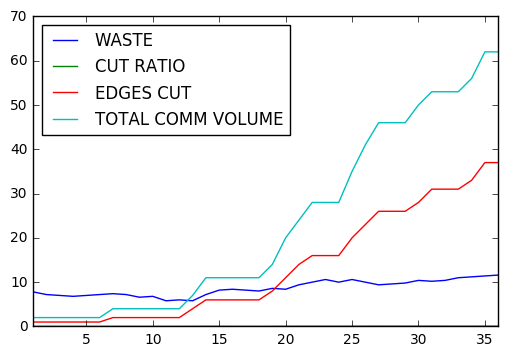

In [7]:
import pandas as pd
rows = list(range(1, len(m)+1))
cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME"]

df = pd.DataFrame(m, index=rows, columns=cols)

df.plot()
df

In [8]:
gp.get_metrics()

Complete graph with 1000 nodes
Writing GML file: /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-173242-all-graph.gml
Writing assignments: /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-173242-all-assignments.txt
Writing edge list (for MaxPerm): /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-173242-all-edges-maxperm.txt
Writing edge list (for OSLOM): /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-173242-all-edges-oslom.txt

Config
-------

file: 173242
num_partitions: 4
num_iterations: 10
prediction_model_cut_off: 0.1
one_shot_alpha: 0.5
restream_batches: 10
use_virtual_nodes: False
virtual_edge_weight: 1.0

Metrics
-------

edges_cut: 37
waste: 11.599999999999996
cut_ratio: 0.05096418732782369
communication_volume: 62
network_permanence: -0.428883
Q: -0.003216803648809664
NQ: -52.092663790515964
Qds: -0.999999999999999
intraEdges: 0.0
interEdges: 34903.846153846156
intraDensity: 